In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from bs4 import BeautifulSoup ## for removing html tags
from tensorflow.keras.preprocessing.text import Tokenizer ## For tokenization
import string
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Stop Words
stopwords = ['a','the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'not', 'are', 'you', 'his', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'who', 'from', 'like', 'so', 'her', 'or', 'just', 'about', 'has', 'out', 'if', 'some', 'what']

In [9]:
## Tokenizing the dataset as per the last chapter
sentences=[]
labels=[]
table = str.maketrans('', '', string.punctuation)
with open('sentiment_analysis.csv', newline="", encoding="utf-8") as csvfile:
     reader = csv.reader(csvfile, delimiter=",")
     next(reader) # Skip header file
     for row in reader:
         # 0 id, 1 label, 2 tweet
         labels.append(int(row[1]))
         sentence = row[2].lower()
         sentence = sentence.replace(",", " , ")
         sentence = sentence.replace(".", " . ")
         sentence = sentence.replace("-", " - ")
         sentence = sentence.replace("/", " / ")
         soup = BeautifulSoup(sentence)
         sentence = soup.get_text()
         words = sentence.split()
         filtered_sentence = ""
         for word in words:
             word = word.translate(table)
             if word not in stopwords:
                 filtered_sentence = filtered_sentence + word + " "
         sentences.append(filtered_sentence)


training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_labels = np.array(training_labels, dtype=np.int32)
testing_labels = np.array(testing_labels, dtype=np.int32)

vocab_size = 750
max_length = 10
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) # Define tokenizer
tokenizer.fit_on_texts(training_sentences) # Fit
word_index = tokenizer.word_index

# Tokenize and then pad sentences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
## For validation
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

C:\Users\Yusuf Solomon\AppData\Local\Temp\ipykernel_11680\3674781703.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7318 - loss: 0.6471 - val_accuracy: 0.7519 - val_loss: 0.5564
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7423 - loss: 0.5394 - val_accuracy: 0.7519 - val_loss: 0.5077
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7445 - loss: 0.4795 - val_accuracy: 0.7658 - val_loss: 0.4190
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8204 - loss: 0.3751 - val_accuracy: 0.8554 - val_loss: 0.3261
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8674 - loss: 0.3106 - val_accuracy: 0.8693 - val_loss: 0.3015
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8786 - loss: 0.2879 - val_accuracy: 0.8756 - val_loss: 0.2947
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8812 - loss: 0.2766 - val_accuracy: 0.8794 - val_loss: 0.2915
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8879 - loss: 0.2684 - val_acc

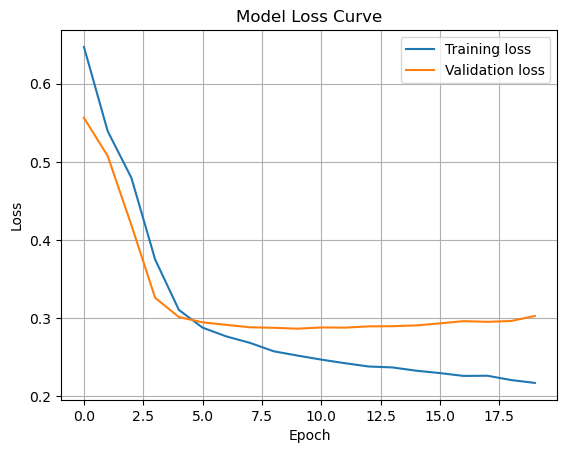

In [15]:
## Using normal NN architecture for NLP, the model treats the sentences as just a pile of words
## In reality, the position of words in a sentence also affects the meaning of the sentence, or the sentiment
## We need a way for the NN to learn sequences in sentences, to be able to differentiate between two sentences that have the same words but in different positions
## Recurrent Neural networks acheives this by passing a bit of info from one neuron to the next, not just to the output
## Long Short Term Memory architecture takes thus further and learns to be able to assign importance to some words over others 
## i.e. it keeps some context in its short term memory and some in the long term memory
## LSTMs can do this forward and backwards in the sentence, learn how words at the beginning affect the end and vice versa
# I would implement a LSTM architecture, stacking two LSTM layers and using dropout reguarization

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
 ])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer= adam , metrics=['accuracy'])

## Plotting the loss curve
history = model.fit(
    training_padded, training_labels,
    validation_data=(test_padded, testing_labels),
    epochs=20,
    batch_size=32
)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

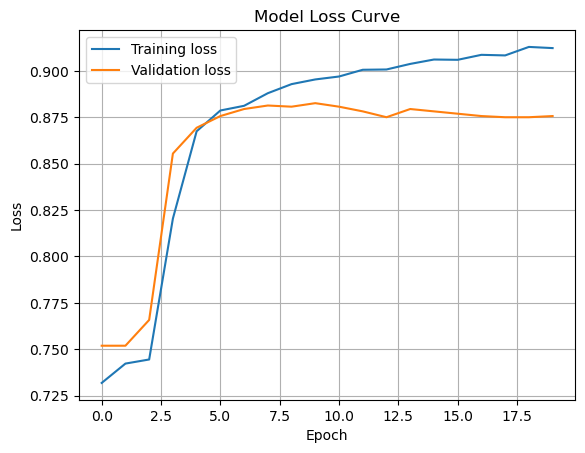

In [17]:
plt.plot(history.history['accuracy'], label='Training loss')
plt.plot(history.history['val_accuracy'], label='Validation loss')

plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
## We do not have to always train our own embedding layer, we can use already trained embedding layers from other models
# Model seems to be overfitting, so i would reduce the number of epochs 

# Dowload the embeddings zip file

!wget --no-check-certificate \ https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.twitter.27B.25d.zip \-O /tmp/glove.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
